In [1]:
import pandas as pd
import os
from nixtla import NixtlaClient
import random
import numpy as np

In [2]:
do_clean = False
# remove all files that are cleaned and start from scratch 
if do_clean:
    path = os.path.join("data", "nba", "data_raw", "parquet")
    files = [f for f in os.listdir(path) if f.endswith('_cleaned.parquet')]
    for file in files:
        os.remove(os.path.join(path, file))

In [8]:
create = True
if create:
    path = os.path.join("data", "nba", "data_raw", "parquet")
    files = [f for f in os.listdir(path) if not f.endswith('_cleaned.parquet') and "@" in f]
    
    lower_threshold = 30
    upper_threshold = 50
    
    i = 0
    
    for file in files:
        # clear the output
        df = pd.read_parquet(os.path.join(path, file))
        df = df.sort_values(by=["event_id", "moment_id"])
        
        old_size = df.shape[0] * len(df.keys())
        
        # Initialize a list to store event ids that need to be removed
        events_to_remove = []
        
        
        moments = pd.to_datetime(df["moment_id"], unit='ms').values.astype(np.int64)// 10**6 
        moments = np.round(moments / 40) * 40
        
        # convert the intervalls from 40 ms to 1 ms (reason: the model takes only 1 ms intervalls)
        first_moment = moments[0]
        moments = np.arange(len(moments)) * 1000 + first_moment
        
        df["moment_id"] = pd.to_datetime(moments, unit='ms')
                
        nan_events = df[df.isnull().any(axis=1)]["event_id"].unique()
        events_to_remove.extend(nan_events)
        
        # Remove the events from the DataFrame
        filtered_df = df[~df["event_id"].isin(events_to_remove)]
        
        # remove duplicates
        filtered_df = filtered_df.drop_duplicates(subset='moment_id', keep='first')
        
        for event_id, event_data in df.groupby("event_id"):
            moments = event_data["moment_id"].values.astype(np.int64) // 10**6 
            # Round each moment ID to modulo 40
            diff_time = np.diff(moments)

            # Check if any time difference within the event is outside the thresholds
            if len(diff_time) != 0 and ((diff_time.min() < lower_threshold) or (diff_time.max() > upper_threshold)):
                events_to_remove.append(event_id)
                
            event_data["moment_id"] = pd.to_datetime(moments, unit='ms')
        
         # remove events with less than 100 moments
        event_counts = filtered_df['event_id'].value_counts()
        filtered_event_ids = event_counts[event_counts >= 100].index.tolist()
        filtered_df = filtered_df[filtered_df['event_id'].isin(filtered_event_ids)]
        
        filtered_df["event_id"] = str(i) + "_" + filtered_df["event_id"].astype(str)
        #filtered_df["moment_id"] = pd.to_datetime(filtered_df["moment_id"], unit='ms')

        i += 1
        
        # Remove rows with NaN values except for event_id and moment_id
        filtered_df = filtered_df.dropna(subset=filtered_df.columns.difference(['event_id', 'moment_id']))
        
        # before and after 
        
        new_size = filtered_df.shape[0] * len(filtered_df.keys())
        
        # print how many events were deleted
        print(f"\r Processing file {file}, Percentage: {round((files.index(file) + 1) / len(files) * 100, 2)}%, Deleted {(old_size - new_size) / old_size * 100:.2f}%", end="")
        
        # save the file, if there are any events left
        if filtered_df.shape[0] > 0:
            filtered_df.to_parquet(os.path.join(path, file.replace(".parquet", "_cleaned.parquet")))

 Processing file WAS@TOR_2015-12-30.parquet, Percentage: 100.0%, Deleted 40.56%%

In [9]:
# Get a list of all parquet files in the directory
path:str = os.path.join("data", "nba", "data_raw", "parquet")

if create:
    files:list[str] = [f for f in os.listdir(path) if f.endswith('_cleaned.parquet')]
    dfs = []
    # concatinate and save the files in each iteration step (it will eventually crash if the files are too big)
    df_combined = pd.DataFrame()
    for i, file in enumerate(files):
        if i == 10:
            break
        print(f"\r Processing file {i+1}/{len(files)}: {file}", end="")
        df = pd.read_parquet(os.path.join(path, file))
        dfs.append(df)

 Processing file 10/618: ATL@MIA_2015-11-03_cleaned.parquet

In [10]:
if create:
    split = 0.5
    
    seed = 42
    random.seed(seed)
    random.shuffle(dfs)
    
    train = dfs[:int(len(dfs) * split)]
    test = dfs[int(len(dfs) * split):]
    
    df_train = pd.concat(train)
    df_test = pd.concat(test)
    
    df_train.to_parquet(os.path.join(path, "train.parquet"))
    df_test.to_parquet(os.path.join(path, "test.parquet"))


In [11]:
if not create:
    # read the data from the parquet files
    df_train = pd.read_parquet(os.path.join(path, "train.parquet"))
    df_test = pd.read_parquet(os.path.join(path, "test.parquet"))

In [12]:
# display nan values and their corresponding columns 
nan_values = df_train.isna().sum()
nan_values = nan_values[nan_values > 0]
nan_values

Series([], dtype: int64)

In [13]:
# chck how many quarter = 5 events are in the data
df_train[df_train['quarter'] == 5]['event_id'].nunique()

0

In [14]:
# drop columns
time_name = "moment_id"
x_target_name = "x_0"
y_target_name = "y_0"
group_name = "event_id"
df_train = df_train.sort_values(by=[group_name, time_name])
df_train = df_train.reset_index(drop=True)

In [15]:
# Function to calculate velocity for each player within each group
#def calculate_velocity(group):
#    for i in range(10):  # Assuming players are indexed from 0 to 9
#        group[f'vel_x_{i}'] = (group[f'x_{i}'] - group[f'x_{i}'].shift()) / (group['moment_id'] - group['moment_id'].shift()) * 1000
#        group[f'vel_y_{i}'] = (group[f'y_{i}'] - group[f'y_{i}'].shift()) / (group['moment_id'] - group['moment_id'].shift()) * 1000
#
#    # Fill NaN values in velocity columns with zeros
#    group.update(group.filter(like='vel').fillna(0))#

#    return group

# Apply the function to each group defined by 'event_id' with group_keys=False
#df = df.groupby('event_id', group_keys=False).apply(calculate_velocity)


In [16]:
# he same function as above but for acceleration
#def calculate_acceleration(group):
#    for i in range(10):  # Assuming players are indexed from 0 to 9
#        group[f'acc_x_{i}'] = (group[f'vel_x_{i}'] - group[f'vel_x_{i}'].shift()) / (group['moment_id'] - group['moment_id'].shift()) * 1000
#        group[f'acc_y_{i}'] = (group[f'vel_y_{i}'] - group[f'vel_y_{i}'].shift()) / (group['moment_id'] - group['moment_id'].shift()) * 1000

# Fill NaN values in acceleration columns with zeros
#    group.update(group.filter(like='acc').fillna(0))

#    return group

# Apply the function to each group defined by 'event_id' with group_keys=False
#df = df.groupby('event_id', group_keys=False).apply(calculate_acceleration)


In [17]:
# cut all events to the same length of 100 moments
df_train = df_train.groupby(group_name).head(100)

# split into input and ground truth (75 and 25 moments)
df_input = df_train.groupby(group_name).head(75)
df_ground_truth = df_train.groupby(group_name).tail(25)


In [18]:
# count number of events
print(df_input[group_name].nunique())

1407


In [19]:
 # create exogenous variables dataframe for TimeGPT model
df_exogenous = df_ground_truth.copy()
for i in range(10):
    df_exogenous = df_exogenous.drop(columns=[f'x_{i}', f'y_{i}'])
df_exogenous = df_exogenous.drop(columns=['ball_radius', 'ball_x', 'ball_y', 'shot_clock', 'game_clock'])
df_exogenous.reset_index(drop=True, inplace=True)

In [20]:
# create models for x and y coordinates
api_key = 'nixtla-tok-BOIzvECbvUfv8IHpO0JMkh6wJo2EfM8jMjJulydjWUDvivYIbiM30nwkHb6hohIelkmV7HdKTu9ddLN3'
x_predict_model = NixtlaClient(api_key=api_key)
y_predict_model = NixtlaClient(api_key=api_key)

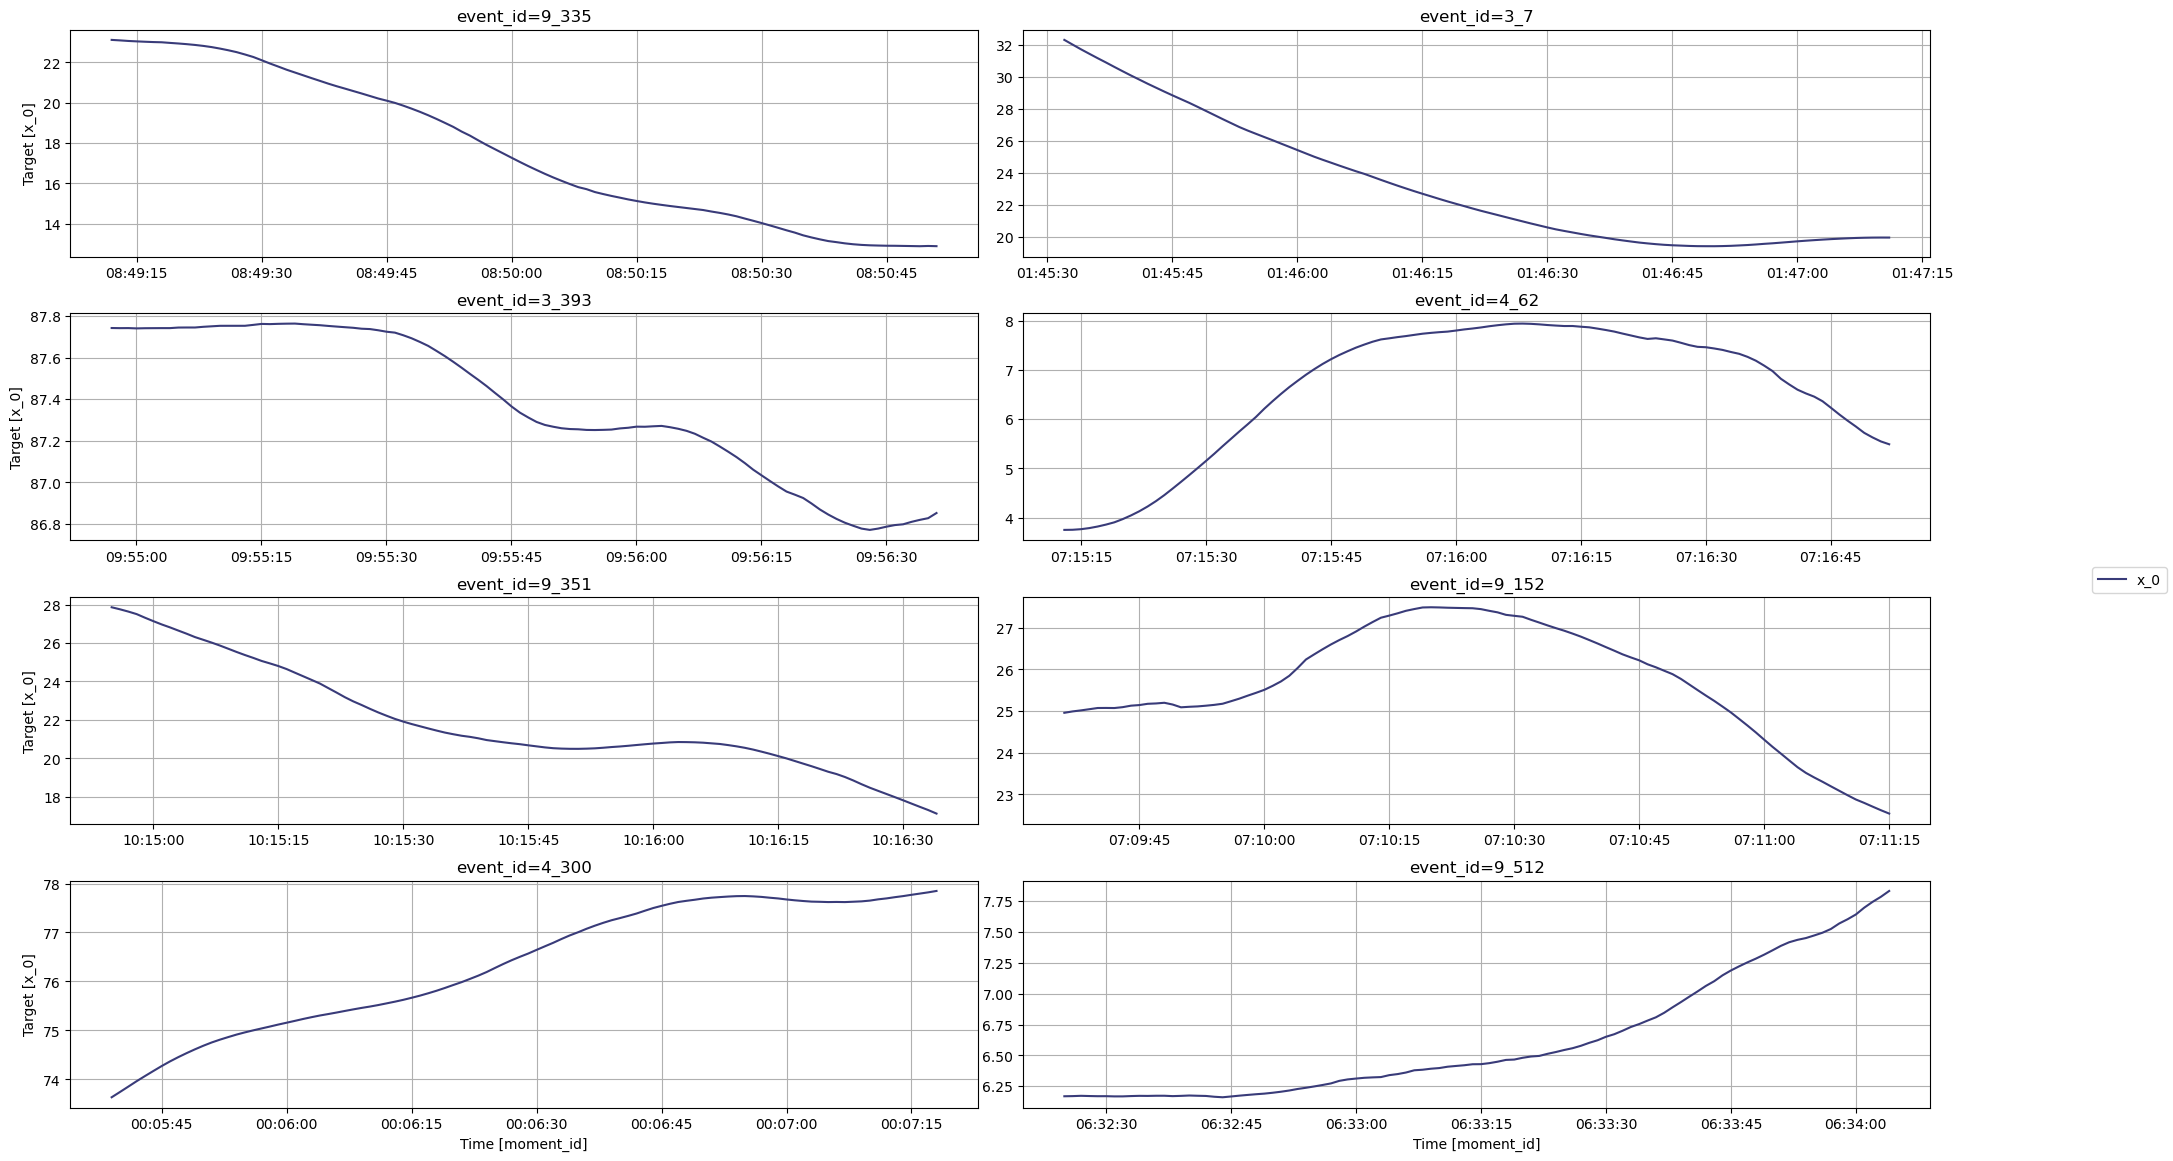

In [21]:
x_predict_model.plot(df_train, id_col=group_name, time_col=time_name, target_col=x_target_name)

In [23]:
# train models
x_output = x_predict_model.forecast(df=df_input, h=25, model='timegpt-1-long-horizon', time_col=time_name, id_col=group_name, freq="s", target_col=x_target_name)
y_output = y_predict_model.forecast(df=df_input, h=25, model='timegpt-1-long-horizon', time_col=time_name, id_col=group_name, freq="s", target_col=y_target_name)


INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
C:\Users\denis\miniconda3\envs\master\Lib\site-packages\utilsforecast\preprocessing.py:179: UserWarning: Some values were lost during filling, please make sure that all your times meet the specified frequency.
For example if you have 'W-TUE' as your frequency, make sure that all your times are actually Tuesdays.
  warnings.warn(
INFO:nixtla.nixtla_client:Restricting input...
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...
INFO:nixtla.nixtla_client:Attempt 1 failed...
INFO:nixtla.nixtla_client:Attempt 2 failed...
INFO:nixtla.nixtla_client:Attempt 3 failed...
INFO:nixtla.nixtla_client:Attempt 4 failed...
INFO:nixtla.nixtla_client:Attempt 5 failed...
INFO:nixtla.nixtla_client:Attempt 6 failed...


ApiError: status_code: 400, body: <!DOCTYPE html>
<html lang="en">
<head>
<meta charset="utf-8">
<title>Error</title>
</head>
<body>
<pre>Bad Request</pre>
</body>
</html>


In [38]:
x_output

,event_id,moment_id,TimeGPT
0,3_1,2015-11-01 19:10:57.001,62.412880
1,3_1,2015-11-01 19:10:57.002,62.373959
2,3_1,2015-11-01 19:10:57.003,62.417980
3,3_1,2015-11-01 19:10:57.004,62.425976
4,3_1,2015-11-01 19:10:57.005,62.395355
...,...,...,...
18670,9_99,2015-11-28 01:32:50.701,81.413155
18671,9_99,2015-11-28 01:32:50.702,81.413155
18672,9_99,2015-11-28 01:32:50.703,81.413467
18673,9_99,2015-11-28 01:32:50.704,81.413589


In [39]:
df_input["moment_id"]

0        2015-11-01 19:10:54.040000000
1        2015-11-01 19:10:54.040999936
2        2015-11-01 19:10:54.041999872
3        2015-11-01 19:10:54.043000064
4        2015-11-01 19:10:54.044000000
                      ...             
702708   2015-11-28 01:13:50.836999936
702709   2015-11-28 01:13:50.838000128
702710   2015-11-28 01:13:50.839000064
702711   2015-11-28 01:13:50.840000000
702712   2015-11-28 01:13:50.840999936
Name: moment_id, Length: 105525, dtype: datetime64[ns]

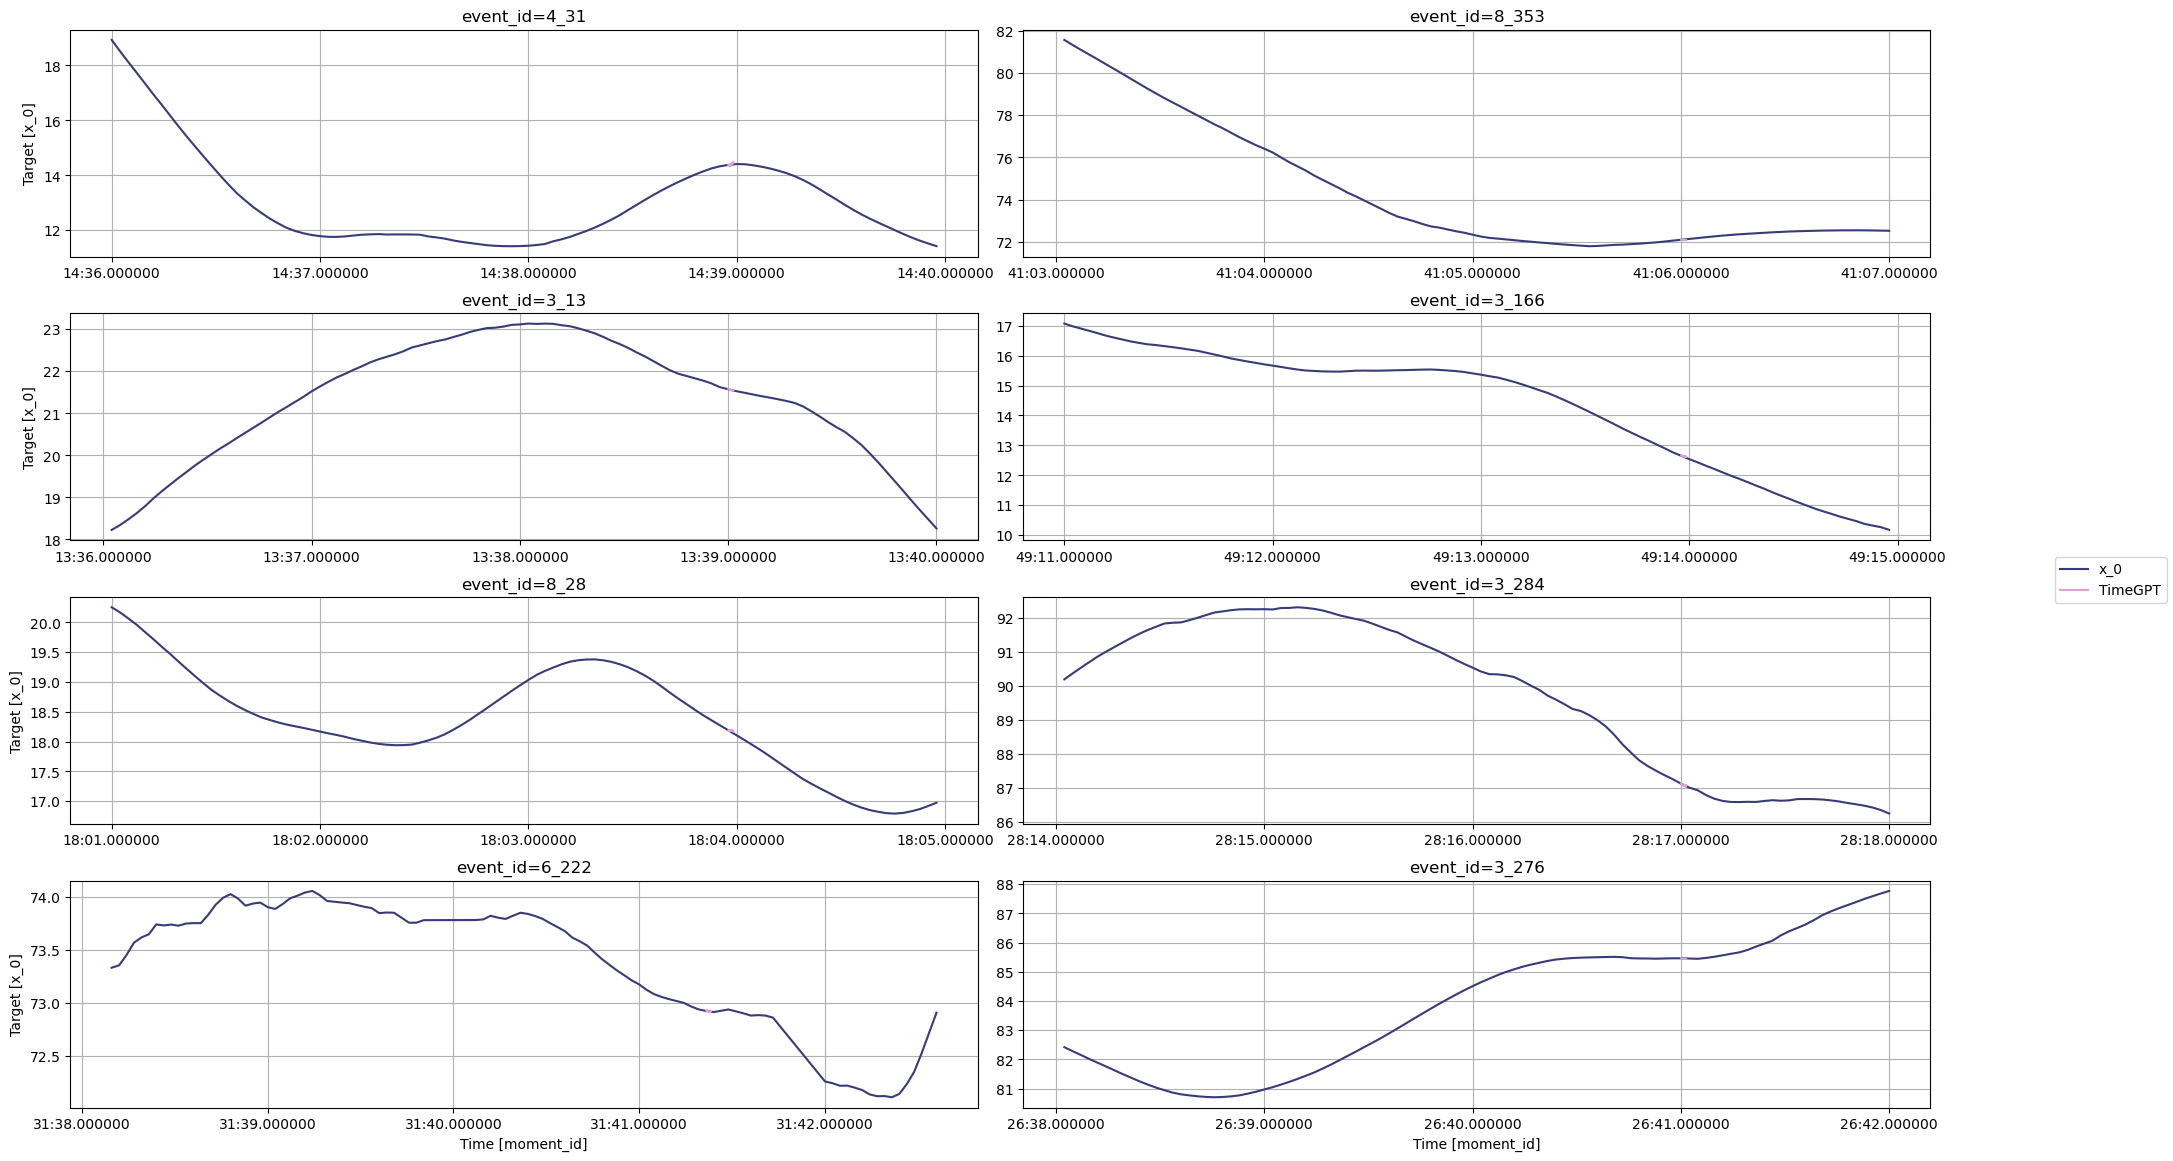

In [18]:
# plot predictions vs ground truth for x and y coordinates
x_predict_model.plot(df_train, x_output, id_col=group_name, time_col=time_name, target_col=x_target_name)

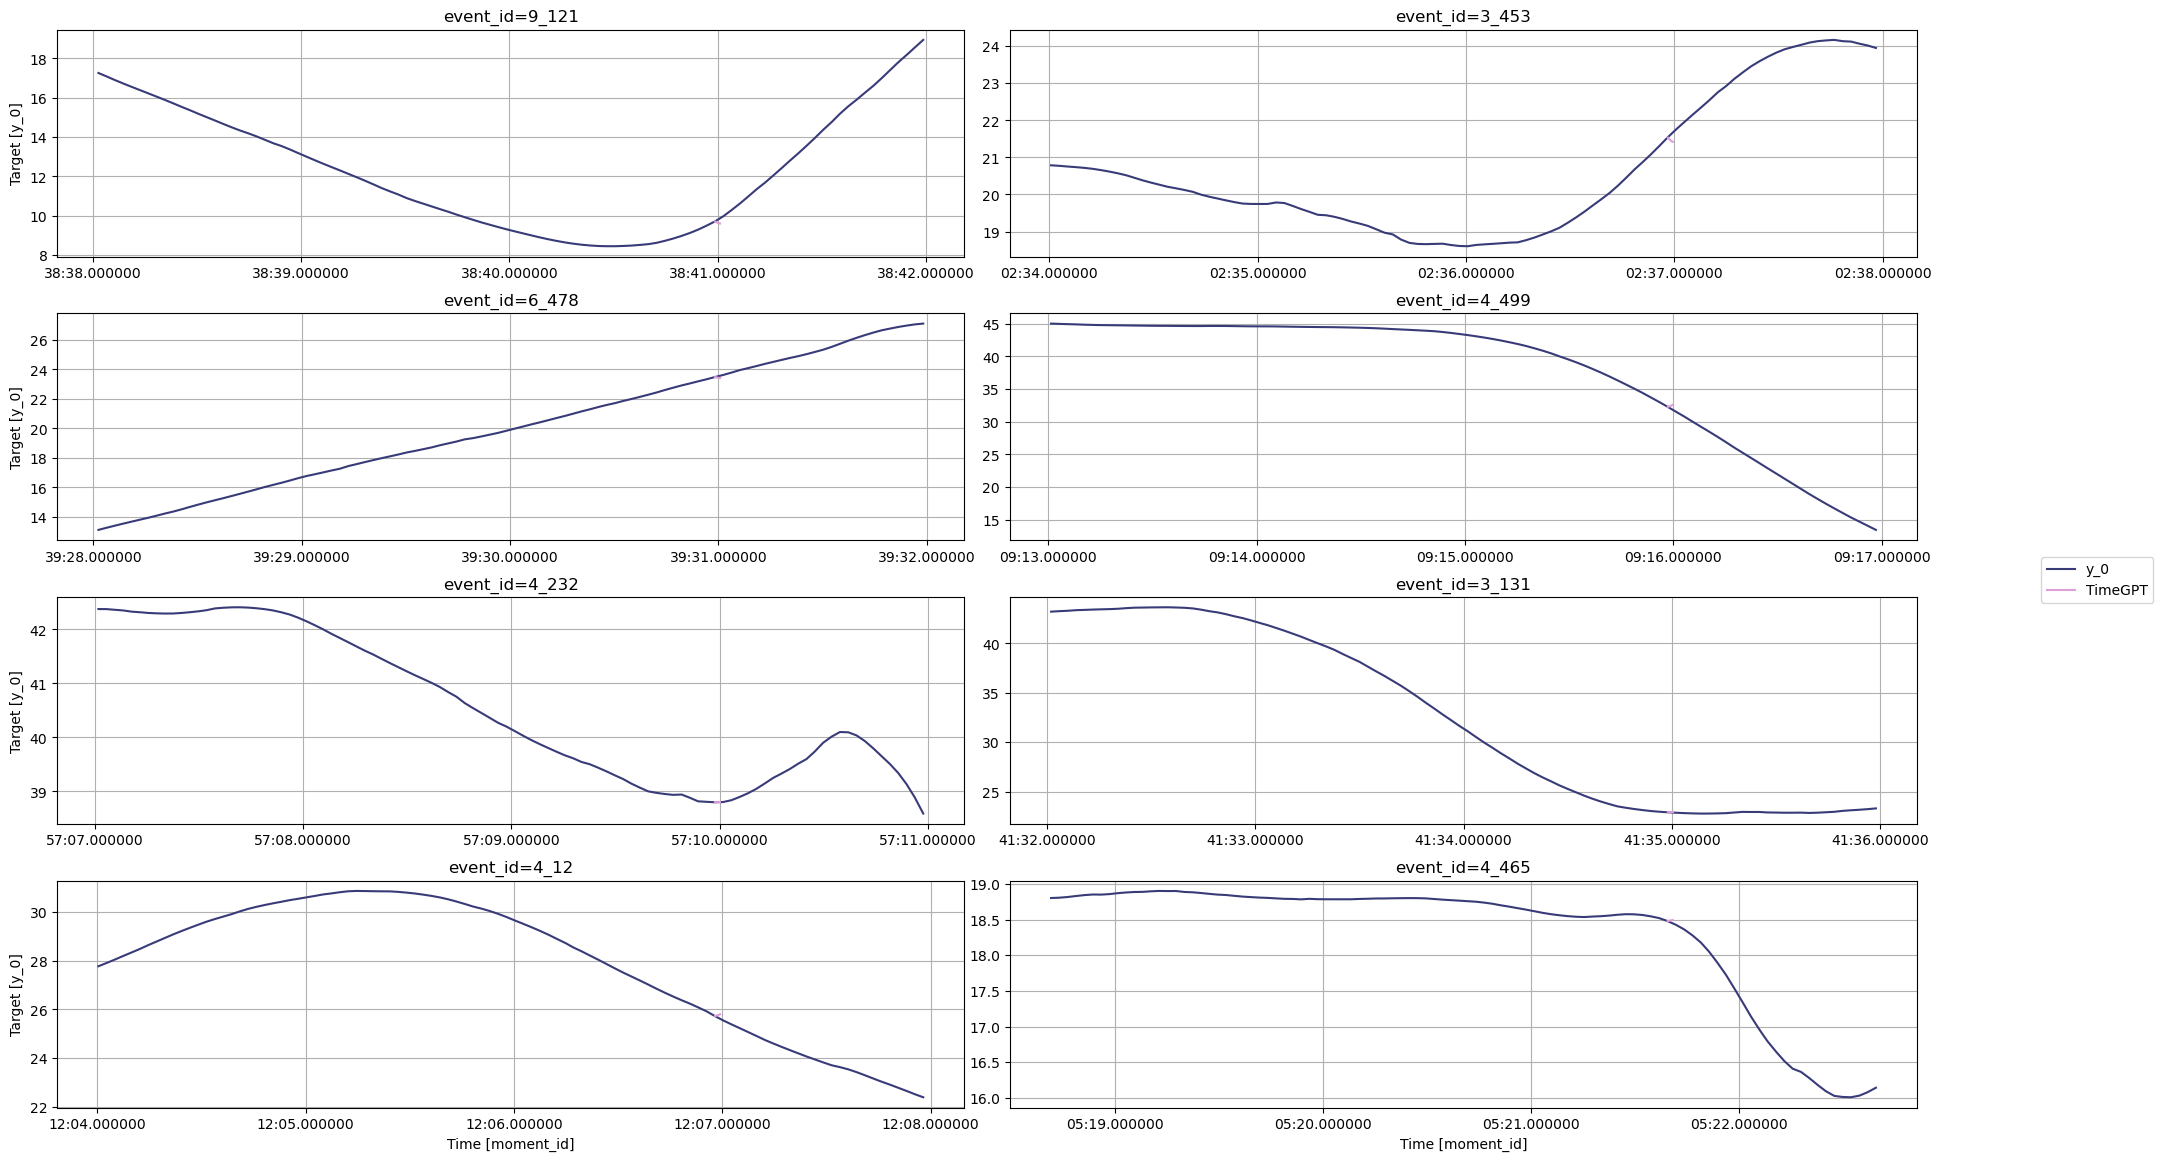

In [90]:
y_predict_model.plot(df_train, y_output, id_col=group_name, time_col=time_name, target_col=y_target_name)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# rename columns to match ground truth
x_output = x_output.rename(columns={'TimeGPT': 'x_0'})
y_output = y_output.rename(columns={'TimeGPT': 'y_0'})

In [ ]:
# plot input coordinates for a few events
event_ids = x_output['event_id'].unique()
for i in range(5, 10):
    print(f'Event {event_ids[i]}')
    plt.figure(i)
    x_input = df_input[df_input['event_id'] == event_ids[i]]['x_0']
    y_input = df_input[df_input['event_id'] == event_ids[i]]['y_0']
    x_predicted = x_output[x_output['event_id'] == event_ids[i]]['x_0']
    y_predicted = y_output[y_output['event_id'] == event_ids[i]]['y_0']
    x_ground_truth = df_ground_truth[df_ground_truth['event_id'] == event_ids[i]]['x_0']
    y_ground_truth = df_ground_truth[df_ground_truth['event_id'] == event_ids[i]]['y_0']
    plt.plot(x_input, y_input, label='Input')
    plt.plot(x_predicted, y_predicted, label='Predicted')
    plt.plot(x_ground_truth, y_ground_truth, label='Ground Truth')
    plt.legend()
    plt.xlabel('x_0')
    plt.ylabel('y_0')
    plt.title(f'Event {event_ids[i]}')




In [ ]:
feet_to_meters_conversion_factor = 0.3048

df_ground_truth.reset_index(drop=True, inplace=True)
x_output.reset_index(drop=True, inplace=True)

df_ground_truth['timestep_within_event'] = df_ground_truth.groupby('event_id').cumcount() + 1
x_output['timestep_within_event'] = x_output.groupby('event_id').cumcount() + 1

merged_df = pd.merge(df_ground_truth, x_output, on=['timestep_within_event', 'event_id'],
                     suffixes=('_truth', '_output'))

selected_columns = ['timestep_within_event', 'x_0_output', 'x_0_truth', 'event_id']
x_error_df = merged_df[selected_columns]

x_error_df['displacement_error'] = x_error_df['x_0_output'] - x_error_df['x_0_truth']

# convert the error to meters
x_error_df['displacement_error'] = x_error_df['displacement_error'] * feet_to_meters_conversion_factor

result_df = x_error_df.groupby('timestep_within_event')['displacement_error'].agg(['mean', 'var']).reset_index()

# Extract relevant columns
timesteps = result_df['timestep_within_event']
mean_values = result_df['mean']
variance_values = result_df['var']

# Plotting
plt.errorbar(timesteps, mean_values, yerr=np.sqrt(variance_values), fmt='o-', label='Mean with Variance')
plt.xlabel('Timestep within Event')
plt.ylabel('Mean x0 with Variance')
plt.title('Mean with Variance for Each Timestep within Event')
plt.legend()
plt.show()

In [ ]:
feet_to_meters_conversion_factor = 0.3048

y_output.reset_index(drop=True, inplace=True)

df_ground_truth['timestep_within_event'] = df_ground_truth.groupby('event_id').cumcount() + 1
y_output['timestep_within_event'] = y_output.groupby('event_id').cumcount() + 1

merged_df = pd.merge(df_ground_truth, y_output, on=['timestep_within_event', 'event_id'],
                     suffixes=('_truth', '_output'))

selected_columns = ['timestep_within_event', 'y_0_output', 'y_0_truth', 'event_id']
y_error_df = merged_df[selected_columns]

y_error_df['displacement_error'] = y_error_df['y_0_output'] - y_error_df['y_0_truth']

# convert the error to meters
y_error_df['displacement_error'] = y_error_df['displacement_error'] * feet_to_meters_conversion_factor

result_df = y_error_df.groupby('timestep_within_event')['displacement_error'].agg(['mean', 'var']).reset_index()

# Extract relevant columns
timesteps = result_df['timestep_within_event']
mean_values = result_df['mean']
variance_values = result_df['var']

# Plotting
plt.errorbar(timesteps, mean_values, yerr=np.sqrt(variance_values), fmt='o-', label='Mean with Variance')
plt.xlabel('Timestep within Event')
plt.ylabel('Mean y0 with Variance')
plt.title('Mean with Variance for Each Timestep within Event')
plt.legend()
plt.show()

In [ ]:
# Combine 'x' and 'y' displacement errors to get total displacement
error_df_combined = pd.merge(x_error_df, y_error_df, on=['timestep_within_event', 'event_id'])
error_df_combined['displacement_error_combined'] = np.sqrt(
    error_df_combined['displacement_error_x'] ** 2 + error_df_combined['displacement_error_y'] ** 2)

# Group by 'timestep_within_event' and calculate mean and variance for combined displacement
result_df_combined = error_df_combined.groupby('timestep_within_event')['displacement_error_combined'].agg(
    ['mean', 'var']).reset_index()

# Extract relevant columns for combined displacement
timesteps_combined = result_df_combined['timestep_within_event']
mean_values_combined = result_df_combined['mean']
variance_values_combined = result_df_combined['var']

# Plotting for combined displacement
plt.errorbar(timesteps_combined, mean_values_combined, yerr=variance_values_combined, fmt='o-',
             label='Mean with Variance (Combined)')
plt.xlabel('Timestep within Event')
plt.ylabel('Mean Combined Displacement with Variance')
plt.title('Mean with Variance for Combined Displacement for Each Timestep within Event')
plt.legend()
plt.savefig('timegpt_displacement_error.png')


In [ ]:
result_df_combined